# Data Wrangling January 2020 #
## Lanie Preston & Floor Kouwenberg ##

Lanie Preston (VU Student Nr: 2629403)

Floor Kouwenberg (VU Student Nr: 2618232)

In [2]:
#read in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup


## Data on USA Dairy Production per Year and Quarter ## 

In [67]:
us_dairy_production = pd.read_excel('annualmilkprodfactors.xlsx', index_col=0)
us_dairy_production = us_dairy_production.dropna(axis=0)
milk_production =  us_dairy_production[['Milk production']]

## Data on Party Divisions per Year ##

In [206]:
#seats per party per year 
senate_division = pd.read_html("https://en.wikipedia.org/wiki/Party_divisions_of_United_States_Congresses")[0].iloc[1100:1117]

#Selecting the right columns from the table. Also renaming the columns and removing the multi-index
senate_division = senate_division[["Years","Senate"]]
senate_division.columns = senate_division.columns.droplevel(0)
senate_division = senate_division.drop(['Others', 'Vacancies'], axis=1)
senate_division = senate_division.rename({"Total": "Democrats", "Anti-Admin[2]": "Republicans", "Pro-Admin[3]": "Other"}, axis='columns')

#Casting the values as integers
senate_division["Democrats"] = senate_division["Democrats"].astype(str).str[0:2].astype(int)
senate_division["Republicans"] = senate_division["Republicans"].astype(str).str[0:2].astype(int)
senate_division["Other"] = senate_division["Other"].astype(str).str[0]
senate_division = senate_division.set_index("Years")

senate_division_per_year = pd.DataFrame(index=[], columns=senate_division.columns)

#Creating an annual table that states the division per year
for index, row in senate_division.iterrows():
    row.name = int(index.split("–")[0])
    senate_division_per_year = senate_division_per_year.append(row)
    row.name = row.name+1
    senate_division_per_year = senate_division_per_year.append(row)
    
senate_division_per_year = senate_division_per_year.fillna(0)
senate_division_per_year

,Democrats,Republicans,Other
1987,55,45,—
1988,55,45,—
1989,55,45,—
1990,55,45,—
1991,56,44,—
1992,56,44,—
1993,57,43,—
1994,57,43,—
1995,47,53,—
1996,47,53,—


## Data on Dollar Amounts of Subsudies paid to Dairy Farmers by the US Government ##

In [73]:
#government payouts by program
#read in separate excel files 
payouts2010 = pd.read_excel('GP_PaymentsUSA2010.xlsx')
payouts2000 = pd.read_excel('GP_PaymentsUSA2000.xlsx')
payouts1990 = pd.read_excel('GP_PaymentsUSA1990.xlsx')

#give all dfs sensible column names 
def clean_df(df):
    if 'Unnamed: 4' in list(df):
        del df['Unnamed: 4']
    df.rename(columns= {'Unnamed: 0': 'Program'}, inplace=True)
    df.rename(columns= {'United States': 'Program'}, inplace=True)
    return df

#clean all dataframes for merging 
payouts1990 = clean_df(payouts1990)
payouts2000 = clean_df(payouts2000)
payouts2010 = clean_df(payouts2010)
#payouts2000[payouts2000.select_dtypes(include=['number']).columns] *= 1000
#payouts2010[payouts2010.select_dtypes(include=['number']).columns] *= 1000
#payouts1990[payouts1990.select_dtypes(include=['number']).columns] *= 1000


payouts_early = pd.merge(payouts1990, payouts2000, how='outer')
payouts_early = payouts_early.drop([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997], axis=1)
all_payouts = pd.merge(payouts_early, payouts2010, how='outer')
search_values = ['dairy','milk']
dairy_payouts = all_payouts[all_payouts['Program'].str.contains('|'.join(search_values),  na=False, case=False)]
dairy_payouts = dairy_payouts.set_index('Program')
dairy_payouts.columns = dairy_payouts.columns.map(int)

In [74]:
lobbies = pd.read_excel("AnnualLobyingOnDairy.xlsx", index_cols=0)
#reset index so years is a column
lobbies_final = lobbies.pivot_table(columns='Year')
all_funding = dairy_payouts.append(lobbies_final)
all_funding = all_funding.fillna(0)
all_funding

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Milk income loss payments,0.0,0.0,0.0,0.0,859642.0,913317.0,205677.0,9587.0,431231.0,73902.0,...,51660.0,-100.0,446572.0,231704.0,-129.0,-40.0,-64.0,-43.0,-20.0,0.0
Dairy Margin Coverage Program,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,686.0,10394.0,19.0,250013.0,214000.0
Lobbies to Democrats,707800.0,0.0,809200.0,0.0,918200.0,0.0,1000000.0,0.0,1100000.0,0.0,...,1600000.0,0.0,999000.0,0.0,791500.0,0.0,943400.0,0.0,821200.0,0.0
Lobbies to Republicans,1300000.0,0.0,2100000.0,0.0,2200000.0,0.0,2400000.0,0.0,2900000.0,0.0,...,2400000.0,0.0,3700000.0,0.0,2800000.0,0.0,3000000.0,0.0,2400000.0,0.0
Total Lobbies,2245000.0,3051110.0,2798900.0,3260000.0,4314700.0,4073436.0,4839800.0,4841312.0,3840045.0,5220448.0,...,5662885.0,6695032.0,7302248.0,8347149.0,6951794.0,7116441.0,6480567.0,6009870.0,7590843.0,5637167.0


## Plots

<function matplotlib.pyplot.show(*args, **kw)>

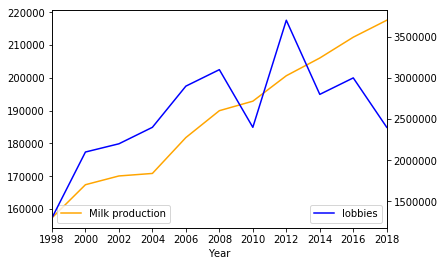

In [87]:
#Plot milk production and lobbies to Republicans on the same graph to see how they correlate 
lobbies = all_funding.iloc[3]
lobbies_every_other = lobbies[::2]

sampled_production = milk_production[::2]
sampled_production = sampled_production.iloc[9:20]


ax3 = sampled_production.plot(color = 'orange', label="Production")
ax4 = lobbies_every_other.plot(secondary_y=True, color='blue', label="lobbies")

ax3.legend(loc=3)
ax3.xaxis.set_ticks(lobbies_every_other.index)
ax4.legend(loc=4)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

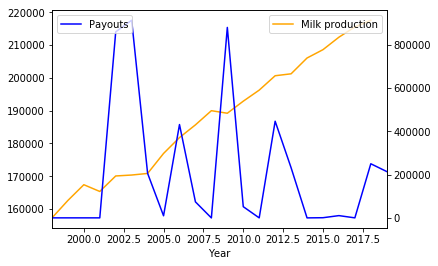

In [105]:
#Plot milk production and Government Payouts to the Dairy Industry to see if they correlate 

subsedies= all_funding.iloc[0:2]
sampled_production = milk_production.iloc[18:41]

ax1 = sampled_production.plot(color = 'orange', label="Production")
ax2 = subsedies.sum().plot(secondary_y=True, color='blue', label="Payouts")

ax1.legend(loc=1)
#ax1.set_xticklabels(sampled_production.index, rotation=90)
ax2.legend(loc=2)

plt.show

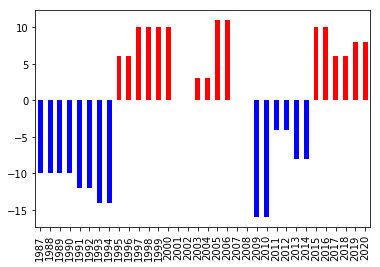

In [207]:
division = senate_division_per_year[["Democrats", "Republicans"]]
division['division'] = division['Republicans'] - division['Democrats']
division['division'].plot(color=(division['division'] > 0).map({True: 'r',
                                                    False: 'b'}), kind ='bar')

<function matplotlib.pyplot.show(*args, **kw)>

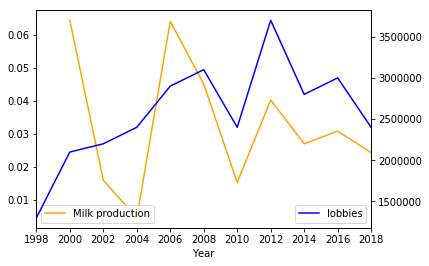

In [107]:
sampled_production = milk_production[::2]
sampled_production = sampled_production.iloc[9:20]

ax3 = sampled_production.pct_change().plot(color = 'orange', label="Growth of production")
ax4 = lobbies_every_other.plot(secondary_y=True, color='blue', label="lobbies")

ax3.legend(loc=3)
ax3.xaxis.set_ticks(sampled_production.index)
ax4.legend(loc=4)

plt.show

Float64Index([1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0,
              2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0,
              2014.0, 2015.0, 2016.0, 2017.0, 2018.0],
             dtype='float64', name='Year')


<function matplotlib.pyplot.show(*args, **kw)>

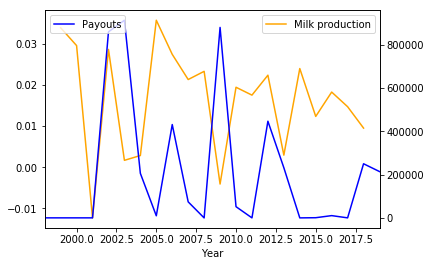

In [104]:
subsedies= all_funding.iloc[0:2]
sampled_production = milk_production.iloc[18:41]

ax1 = sampled_production.pct_change().plot(color = 'orange', label="Growth in production")
ax2 = subsedies.sum().plot(secondary_y=True, color='blue', label="Payouts")

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show